<a href="https://colab.research.google.com/github/pringleshu/2025-1_CV/blob/main/%EC%8B%A4%ED%97%98C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import time, copy, math
from collections import defaultdict
import pandas as pd
from IPython.display import display
import seaborn as sns
import re

In [2]:
SEED = 50 # 재현성
torch.manual_seed(SEED)
np.random.seed(SEED)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # GPU 우선 사용


INPUT_SIZE = 8 * 8       # 입력 이미지 크기
NUM_CLASSES = 10         # 최종 분류 클래스 수
BATCH_SIZE  = 128        # 미니배치 크기
EPOCHS      = 30         # 총 학습 에폭 수
GAMMA       = 0.9        # ExponentialLR 스케줄러 감마 값
LR_LIST     = [0.1, 0.01, 0.001] # 테스트할 초기 학습률
OPT_CONFIGS = {          # 실험 대상 옵티마이저 정의
    'SGD'           : lambda params, lr: optim.SGD(params, lr=lr),
    'SGD+Momentum'  : lambda params, lr: optim.SGD(params, lr=lr, momentum=0.9),
    'Adam'          : lambda params, lr: optim.Adam(params, lr=lr)
}
OPTIMIZER_NAMES = list(OPT_CONFIGS.keys()) # 옵티마이저 이름 리스트
SCHEDULER_OPTIONS = [True, False]          # 스케줄러 사용 여부 옵션

In [3]:
digits = load_digits() # Digits 데이터셋 로드
X_data, y_data = digits.data, digits.target


X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=SEED, stratify=y_data) # 훈련/테스트 데이터 분리


X_train = X_train.astype(np.float32) / 16.0#  데이터 스케일링 ([0,1] 범위로) 및 타입 변환
X_test = X_test.astype(np.float32) / 16.0

X_train_tensor = torch.tensor(X_train) # PyTorch 텐서로 변환
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

X_train_tensor = (X_train_tensor - 0.5) / 0.5 # 추가 정규화 ([-1,1] 범위로)
X_test_tensor = (X_test_tensor - 0.5) / 0.5

train_ds = TensorDataset(X_train_tensor, y_train_tensor) # TensorDataset 및 DataLoader 생성
test_ds  = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=torch.cuda.is_available())
test_loader  = DataLoader(test_ds , batch_size=BATCH_SIZE, shuffle=False,num_workers=0, pin_memory=torch.cuda.is_available())

In [4]:
def make_mlp(): # MLP 모델 생성 함수
    # 간단한 Sequential 모델: Flatten -> Linear -> ReLU -> Linear -> ReLU -> Linear
    return nn.Sequential(
        nn.Flatten(), nn.Linear(INPUT_SIZE, 256), nn.ReLU(),
        nn.Linear(256, 128), nn.ReLU(), nn.Linear(128, NUM_CLASSES)
    ).to(DEVICE)

In [5]:
def train_one_epoch(model, loader, loss_fn, optimizer, grad_key=None): # 단일 에폭 학습 함수
    model.train() # 모델을 훈련 모드로 설정
    running_loss, correct, total = 0.0, 0, 0

    for batch_idx, (X, y) in enumerate(loader): # 미니배치 반복
        X, y = X.to(DEVICE), y.to(DEVICE)

        logits = model(X) # 순전파
        loss   = loss_fn(logits, y) # 손실 계산

        optimizer.zero_grad() # 그래디언트 초기화
        loss.backward() # 역전파

        # (분석용)
        if grad_key is not None and batch_idx == len(loader) - 1:
            total_norm_epoch = 0.0
            layer_norms_tmp = {}
            for name, p in model.named_parameters():
                if p.grad is None: continue
                param_norm = p.grad.detach().data.norm(2).item()
                total_norm_epoch += param_norm ** 2
                layer_name = None # 레이어 이름 매핑 (FC1, FC2, FC3)
                if name.startswith('1.'): layer_name = 'FC1'
                elif name.startswith('3.'): layer_name = 'FC2'
                elif name.startswith('5.'): layer_name = 'FC3'
                if layer_name:
                    layer_norms_tmp.setdefault(layer_name, 0.0)
                    layer_norms_tmp[layer_name] += param_norm ** 2
            grad_total_norms[grad_key].append(math.sqrt(total_norm_epoch))
            for ln, sq_sum in layer_norms_tmp.items():
                grad_layer_norms[grad_key][ln].append(math.sqrt(sq_sum))

        optimizer.step() # 파라미터 업데이트

        running_loss += loss.item() * X.size(0) # 손실 및 정확도 통계 누적
        preds  = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total   += y.size(0)

    avg_loss = running_loss / total
    acc      = correct / total
    return avg_loss, acc

In [6]:
@torch.no_grad() # 평가 시 그래디언트 계산 비활성화
def evaluate(model, loader, loss_fn): # 모델 평가 함수
    model.eval() # 모델을 평가 모드로 설정
    running_loss, correct, total = 0.0, 0, 0
    for X, y in loader: # 테스트 데이터로 반복
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits = model(X)
        loss   = loss_fn(logits, y)
        running_loss += loss.item() * X.size(0)
        preds  = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total   += y.size(0)
    avg_loss = running_loss / total
    acc      = correct / total
    return avg_loss, acc

In [7]:
history = defaultdict(lambda: defaultdict(list))
grad_total_norms  = defaultdict(list)
grad_layer_norms  = defaultdict(lambda: defaultdict(list))

# 스케줄러 사용 여부에 따라 외부 루프 실행
for use_scheduler in SCHEDULER_OPTIONS:
    scheduler_status_str = "Scheduler" if use_scheduler else "NoScheduler"

    # 각 옵티마이저 및 학습률에 대해 내부 루프 실행
    for opt_name, opt_factory in OPT_CONFIGS.items():
        for lr_initial in LR_LIST:
            print(f'\n--- Optimizer: {opt_name} | Initial LR: {lr_initial} | Scheduler: {scheduler_status_str} (Digits Dataset) ---')

            model = make_mlp() # 새 모델 생성
            optimizer = opt_factory(model.parameters(), lr=lr_initial) # 옵티마이저 설정

            scheduler = None # 스케줄러 초기화
            if use_scheduler: # 스케줄러 사용 시 ExponentialLR 적용
                scheduler = ExponentialLR(optimizer, gamma=GAMMA)

            key = f'{opt_name} (lr={lr_initial}, {scheduler_status_str})'# 고유 키

            start_time = time.time() # 시작 시간
            for epoch in range(1, EPOCHS + 1): # 에폭만큼 학습 반복
                train_loss, train_acc = train_one_epoch(model, train_loader, loss_fn=nn.CrossEntropyLoss(), optimizer=optimizer, grad_key=key) # 훈련 및 평가
                val_loss, val_acc = evaluate(model, test_loader, loss_fn=nn.CrossEntropyLoss())

                current_lr = optimizer.param_groups[0]['lr'] # 현재 학습률 확인

                if scheduler: # 스케줄러 사용 시 업데이트
                    scheduler.step()

                # 학습 결과 기록 (손실, 정확도, 학습률)
                history[key]['train_loss'].append(train_loss)
                history[key]['val_loss'].append(val_loss)
                history[key]['train_acc'].append(train_acc)
                history[key]['val_acc'].append(val_acc)
                history[key]['lr'].append(current_lr)

                # 일정 주기마다 학습 진행 상황 출력
                if epoch % 10 == 0 or epoch == 1 or epoch == EPOCHS:
                    print(f'Epoch {epoch:02d}/{EPOCHS} | LR: {current_lr:.6f} '
                          f'| Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} '
                          f'| Train Acc: {train_acc*100:6.2f}%, Val Acc: {val_acc*100:6.2f}%')

            elapsed_time = time.time() - start_time # 종료 시간
            print(f'실험 완료: {key} (소요 시간: {elapsed_time:.2f}s)\n')


--- Optimizer: SGD | Initial LR: 0.1 | Scheduler: Scheduler (Digits Dataset) ---
Epoch 01/30 | LR: 0.100000 | Train Loss: 2.2407, Val Loss: 2.1401 | Train Acc:  33.40%, Val Acc:  57.22%
Epoch 10/30 | LR: 0.038742 | Train Loss: 0.4786, Val Loss: 0.4838 | Train Acc:  90.74%, Val Acc:  91.11%
Epoch 20/30 | LR: 0.013509 | Train Loss: 0.2924, Val Loss: 0.3345 | Train Acc:  94.08%, Val Acc:  93.33%
Epoch 30/30 | LR: 0.004710 | Train Loss: 0.2564, Val Loss: 0.3015 | Train Acc:  94.43%, Val Acc:  93.61%
실험 완료: SGD (lr=0.1, Scheduler) (소요 시간: 1.53s)


--- Optimizer: SGD | Initial LR: 0.01 | Scheduler: Scheduler (Digits Dataset) ---
Epoch 01/30 | LR: 0.010000 | Train Loss: 2.3077, Val Loss: 2.2980 | Train Acc:   4.87%, Val Acc:   4.17%
Epoch 10/30 | LR: 0.003874 | Train Loss: 2.2183, Val Loss: 2.2159 | Train Acc:  51.77%, Val Acc:  50.83%
Epoch 20/30 | LR: 0.001351 | Train Loss: 2.1786, Val Loss: 2.1792 | Train Acc:  65.14%, Val Acc:  62.22%
Epoch 30/30 | LR: 0.000471 | Train Loss: 2.1638, Val 

In [8]:
def parse_experiment_key(key_string): # 실험 키 파싱 함수
    match = re.match(r"(.+?) \(lr=([\d.]+), (Scheduler|NoScheduler)\)", key_string)
    if not match: return "Unknown", "Unknown", "Unknown"
    return match.group(1), match.group(2), match.group(3)

In [21]:
def plot_metrics_per_optimizer(history_data, target_optimizer_name, metric_keys, ylabels, base_title):
    num_plots = len(metric_keys) #특정 옵티마이저의 학습 메트릭을 시각화
    plt.figure(figsize=(12, 4 * num_plots))

    filtered_data_for_optimizer = {
        k: v for k, v in history_data.items() if k.startswith(target_optimizer_name)
    }
    if not filtered_data_for_optimizer: # 데이터 없으면 종료
        print(f"No data to plot for optimizer: {target_optimizer_name}")
        plt.close(); return

    for i, (metric_key, ylabel) in enumerate(zip(metric_keys, ylabels)): # 각 메트릭에 대해 서브플롯 생성
        ax = plt.subplot(num_plots, 1, i + 1)
        for k, data in filtered_data_for_optimizer.items(): # 필터링된 데이터로 라인 플롯
            opt_name_from_key, lr_val_str, sched_status_from_key = parse_experiment_key(k)

            # LR 및 스케줄러 상태에 따른 라인 스타일/색상/투명도/두께 설정
            base_style = '-'
            if "0.1" == lr_val_str: base_style = '-'
            elif "0.01" == lr_val_str: base_style = '--'
            elif "0.001" == lr_val_str: base_style = ':'
            else: base_style = '-.'
            color_map = {'SGD': 'red', 'SGD+Momentum': 'green', 'Adam': 'blue'}
            color = color_map.get(opt_name_from_key, 'black')
            final_style, alpha_val, line_width = base_style, 0.8, 1.8
            label_suffix = f"(lr={lr_val_str}, {sched_status_from_key})"
            if "NoScheduler" == sched_status_from_key: # 스케줄러 미사용 시 스타일 조정
                alpha_val, line_width = 0.6, 1.2
                if metric_key == 'lr': final_style = ':' if base_style == '-' else '-.'
                else: final_style = ':' if base_style == '-' else '-.'

            if metric_key in data and data[metric_key]: # 데이터가 있으면 플롯
                ax.plot(data[metric_key], label=label_suffix, linestyle=final_style, color=color, alpha=alpha_val, linewidth=line_width)

        plt.xlabel('Epoch'); plt.ylabel(ylabel); plt.title(f'{ylabel} vs. Epoch') # 플롯 공통 설정
        plt.legend(fontsize='small', loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid(True, linestyle='--', alpha=0.6)

        if metric_key == 'lr': # LR 그래프 Y축 범위 자동 조정 (가독성 향상)
            min_lr_overall, max_lr_overall, has_lr_data = float('inf'), float('-inf'), False
            for k_data_val in filtered_data_for_optimizer.values():
                if 'lr' in k_data_val and k_data_val['lr']:
                    min_lr_overall = min(min_lr_overall, min(k_data_val['lr']))
                    max_lr_overall = max(max_lr_overall, max(k_data_val['lr']))
                    has_lr_data = True
            if has_lr_data:
                plt.ylim(min_lr_overall - (0.001 if max_lr_overall > min_lr_overall else 0.005),
                         max_lr_overall + (0.001 if max_lr_overall > min_lr_overall else 0.005))

    plt.suptitle(f'{base_title} for {target_optimizer_name}', fontsize=16) # 전체 그림 제목
    plt.tight_layout(rect=[0, 0, 0.85, 0.96]) # 레이아웃 조정
    plt.show()

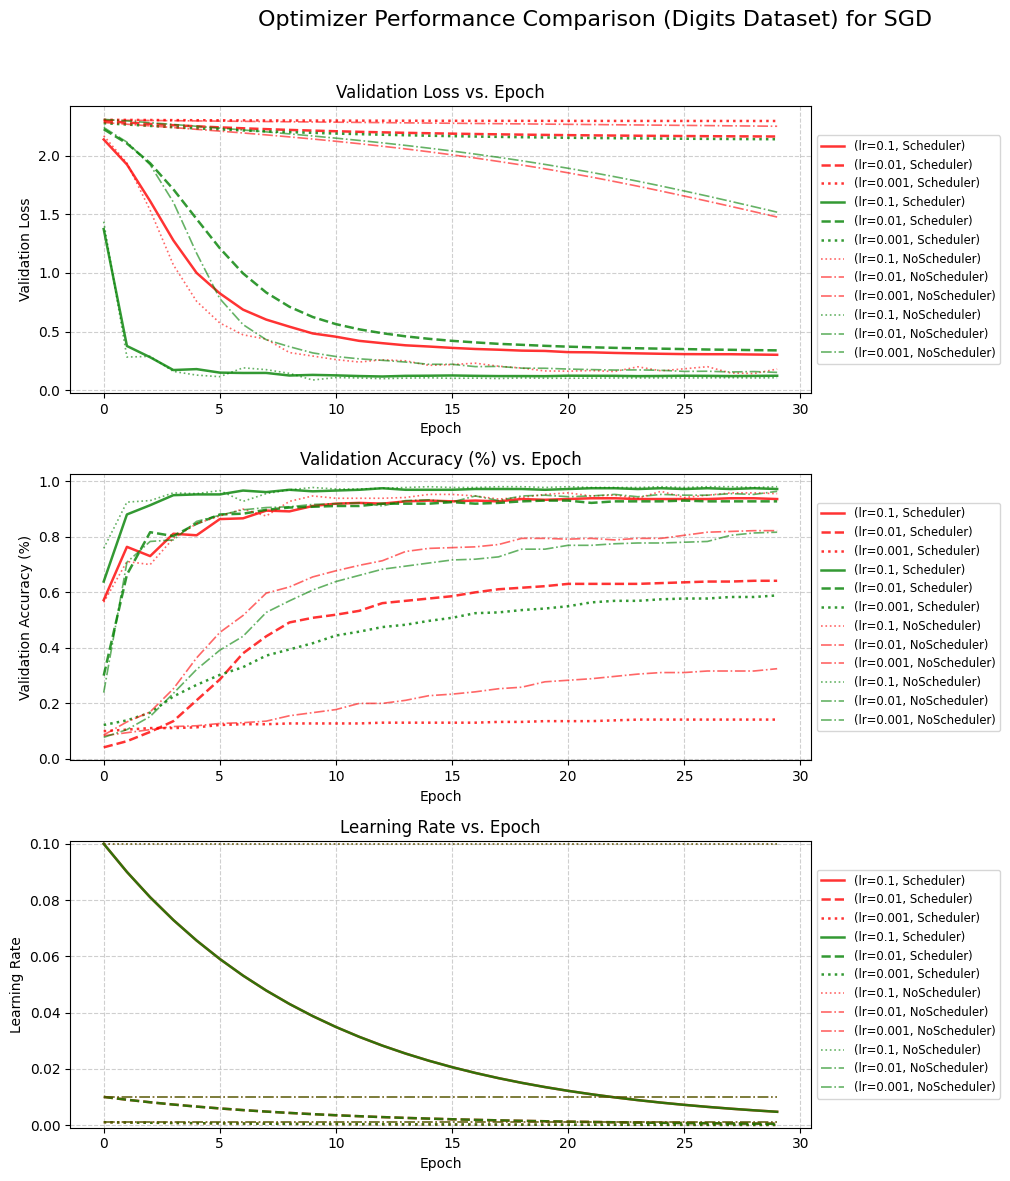

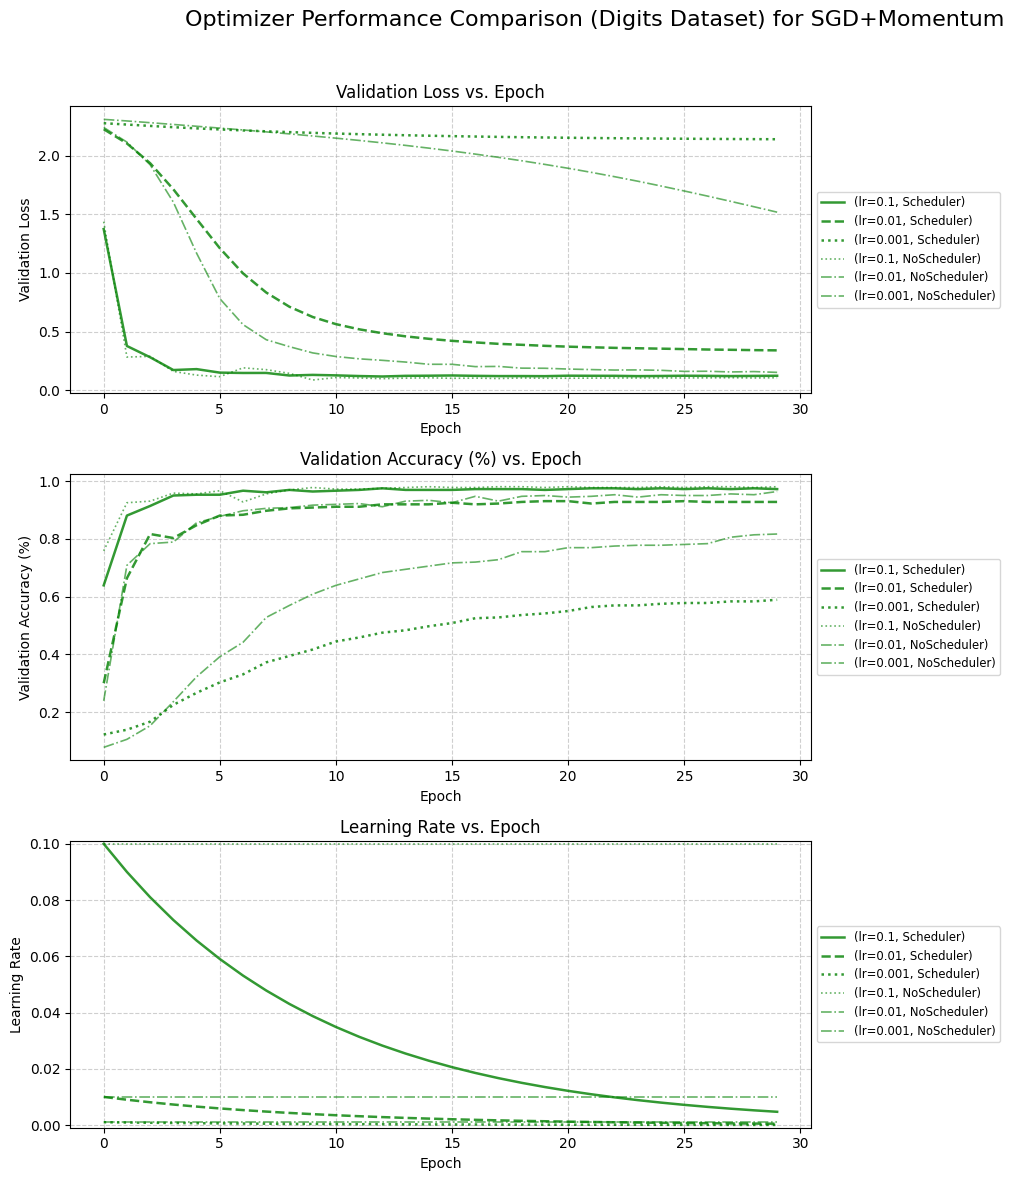

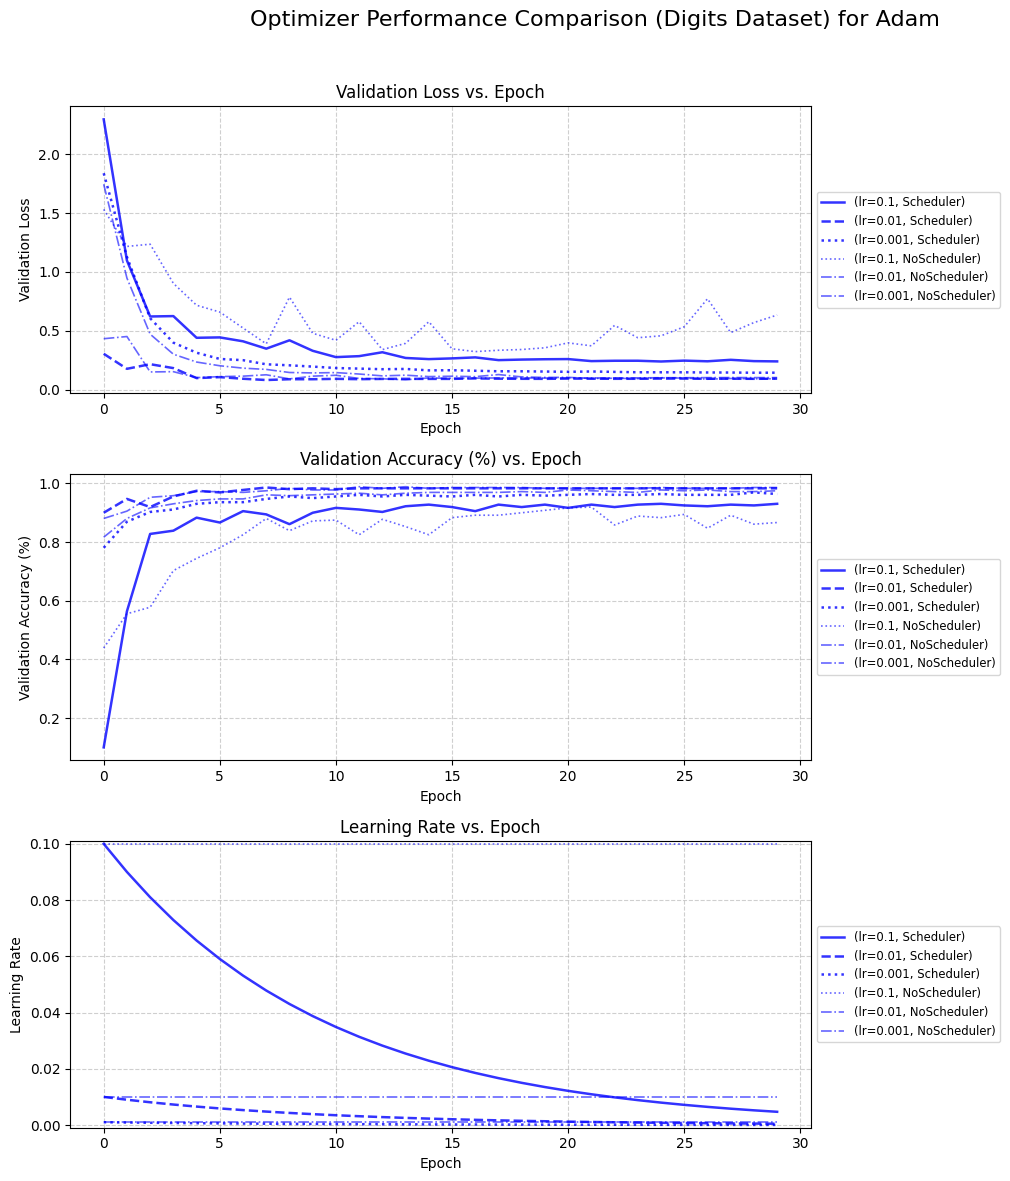

,"Setting (Opt, LR, Scheduler)",최종 정확도 (%),Loss 최솟값,수렴 Epoch (Val Loss Min)
17,"Adam (lr=0.001, NoScheduler)",97.50,0.0909,27
8,"Adam (lr=0.001, Scheduler)",96.39,0.1459,29
16,"Adam (lr=0.01, NoScheduler)",98.61,0.0861,14
7,"Adam (lr=0.01, Scheduler)",98.33,0.0840,8
15,"Adam (lr=0.1, NoScheduler)",86.67,0.3249,17
6,"Adam (lr=0.1, Scheduler)",93.06,0.2411,25
11,"SGD (lr=0.001, NoScheduler)",32.50,2.2531,30
2,"SGD (lr=0.001, Scheduler)",14.17,2.2982,30
10,"SGD (lr=0.01, NoScheduler)",82.22,1.4778,30
1,"SGD (lr=0.01, Scheduler)",64.17,2.1655,30


In [19]:
for opt_to_plot in OPTIMIZER_NAMES: # 각 옵티마이저별로 학습 메트릭 그래프 생성
    plot_metrics_per_optimizer(history, opt_to_plot,
                               ['val_loss', 'val_acc', 'lr'],
                               ['Validation Loss', 'Validation Accuracy (%)', 'Learning Rate'],
                               'Optimizer Performance Comparison (Digits Dataset)')

summary_rows = [] # 요약 정보를 담을 리스트
for k in history: # 모든 실험 결과에 대해 반복
    if history[k]['val_loss']:
        best_val_loss_epoch_idx = np.argmin(history[k]['val_loss'])
        best_val_loss_epoch = best_val_loss_epoch_idx + 1
        final_val_acc = history[k]['val_acc'][-1] * 100
        min_val_loss = history[k]['val_loss'][best_val_loss_epoch_idx]
    else: best_val_loss_epoch, final_val_acc, min_val_loss = 'N/A', 'N/A', 'N/A' # 데이터 없을 시 N/A
    summary_rows.append({ # 딕셔너리 형태로 추가
        'Setting (Opt, LR, Scheduler)' : k,
        '최종 정확도 (%)'             : f"{final_val_acc:.2f}" if isinstance(final_val_acc, float) else final_val_acc,
        'Loss 최솟값'               : f"{min_val_loss:.4f}" if isinstance(min_val_loss, float) else min_val_loss,
        '수렴 Epoch (Val Loss Min)'   : best_val_loss_epoch
    })
summary_df = pd.DataFrame(summary_rows) # Pandas DataFrame으로 변환
display(summary_df.sort_values(by=['Setting (Opt, LR, Scheduler)'])) # 정렬하여 출력

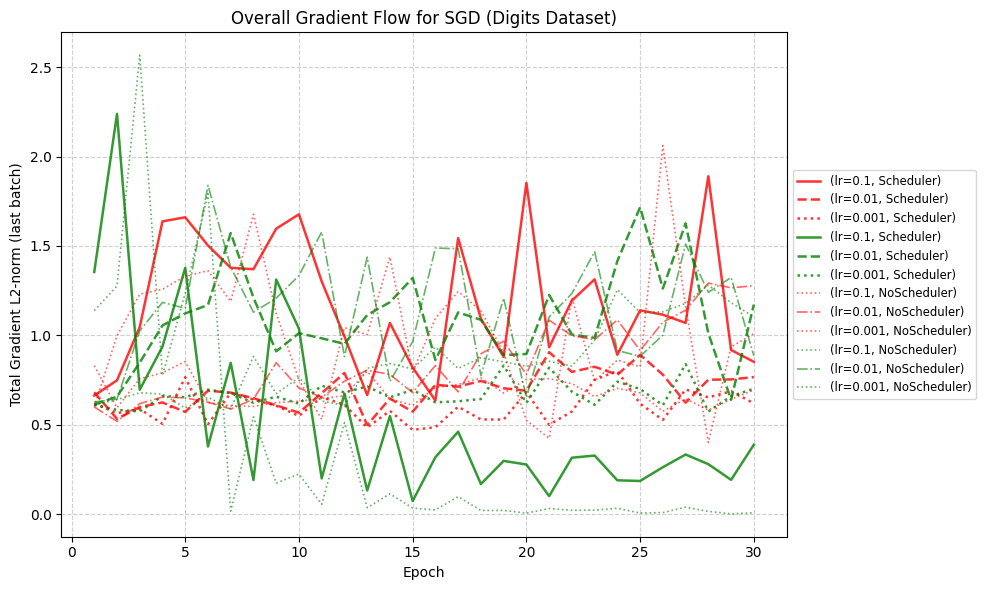

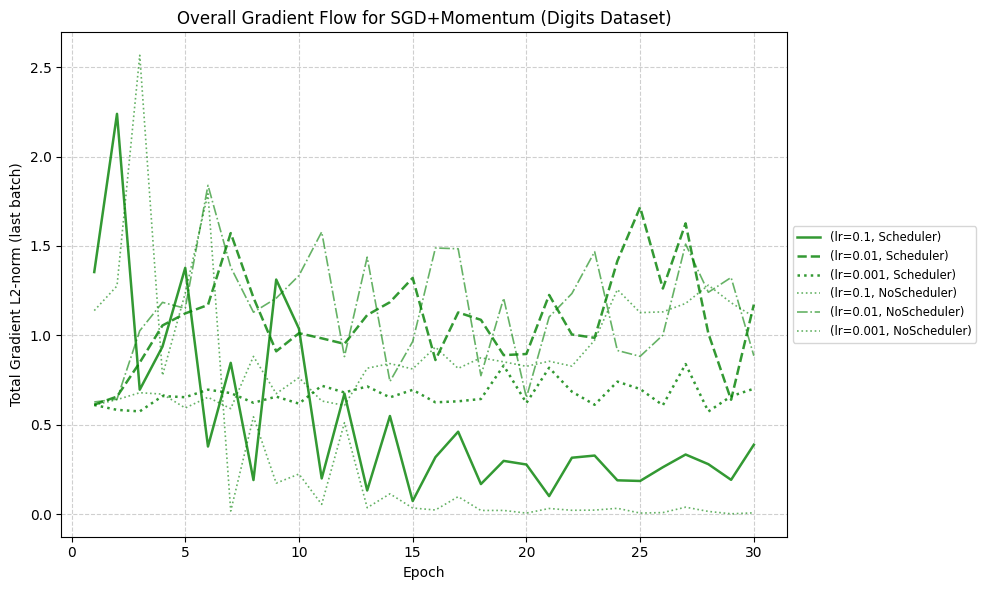

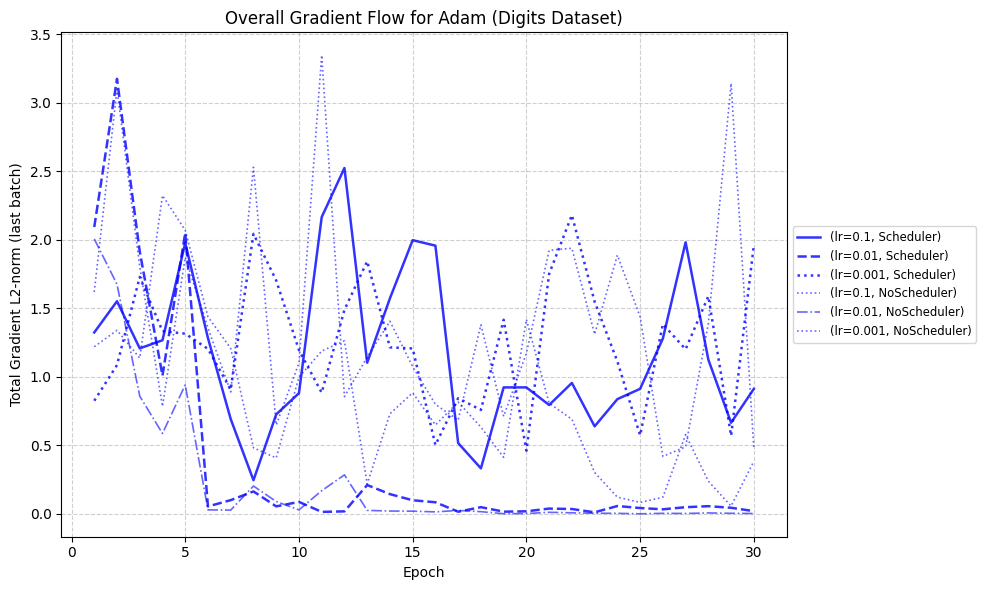

In [14]:
for opt_to_plot in OPTIMIZER_NAMES: # 각 옵티마이저에 대해 반복
    plt.figure(figsize=(12, 6))
    ax = plt.gca()
    has_data_for_opt = False # 데이터 존재 여부 플래그

    # 대상 옵티마이저의 그래디언트 norm 데이터 필터링
    filtered_grad_norms = {k: v for k, v in grad_total_norms.items() if k.startswith(opt_to_plot)}
    if not filtered_grad_norms: # 데이터 없으면 종료
        print(f"No gradient norm data to plot for optimizer: {opt_to_plot}"); plt.close(); continue

    for k, norms in filtered_grad_norms.items(): # 필터링된 데이터로 라인 플롯
        if norms: # norm 데이터가 있으면
            has_data_for_opt = True
            opt_name_from_key, lr_val_str, sched_status_from_key = parse_experiment_key(k)
            # 라인 스타일/색상/투명도/두께 설정 (위의 plot_metrics_per_optimizer와 유사)
            base_style = '-'
            if "0.1" == lr_val_str: base_style = '-'
            elif "0.01" == lr_val_str: base_style = '--'
            elif "0.001" == lr_val_str: base_style = ':'
            else: base_style = '-.'
            color_map = {'SGD': 'red', 'SGD+Momentum': 'green', 'Adam': 'blue'}
            color = color_map.get(opt_name_from_key, 'black')
            final_style, alpha_val, line_width = base_style, 0.8, 1.8
            label_suffix = f"(lr={lr_val_str}, {sched_status_from_key})"
            if "NoScheduler" == sched_status_from_key:
                alpha_val, line_width = 0.6, 1.2
                if base_style == '-': final_style = ':'
                elif base_style == '--': final_style = '-.'
            ax.plot(range(1, len(norms) + 1), norms, label=label_suffix, linestyle=final_style, color=color, alpha=alpha_val, linewidth=line_width)

    if not has_data_for_opt: # 실제 그려진 데이터가 없으면 종료
        print(f"No gradient norm data actually plotted for optimizer: {opt_to_plot}"); plt.close(); continue

    # 플롯 공통 설정
    plt.xlabel('Epoch'); plt.ylabel('Total Gradient L2-norm (last batch)')
    plt.title(f'Overall Gradient Flow for {opt_to_plot} (Digits Dataset)')
    plt.legend(fontsize='small', loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout(rect=[0, 0, 0.83, 1]) # 레이아웃 조정
    plt.show()

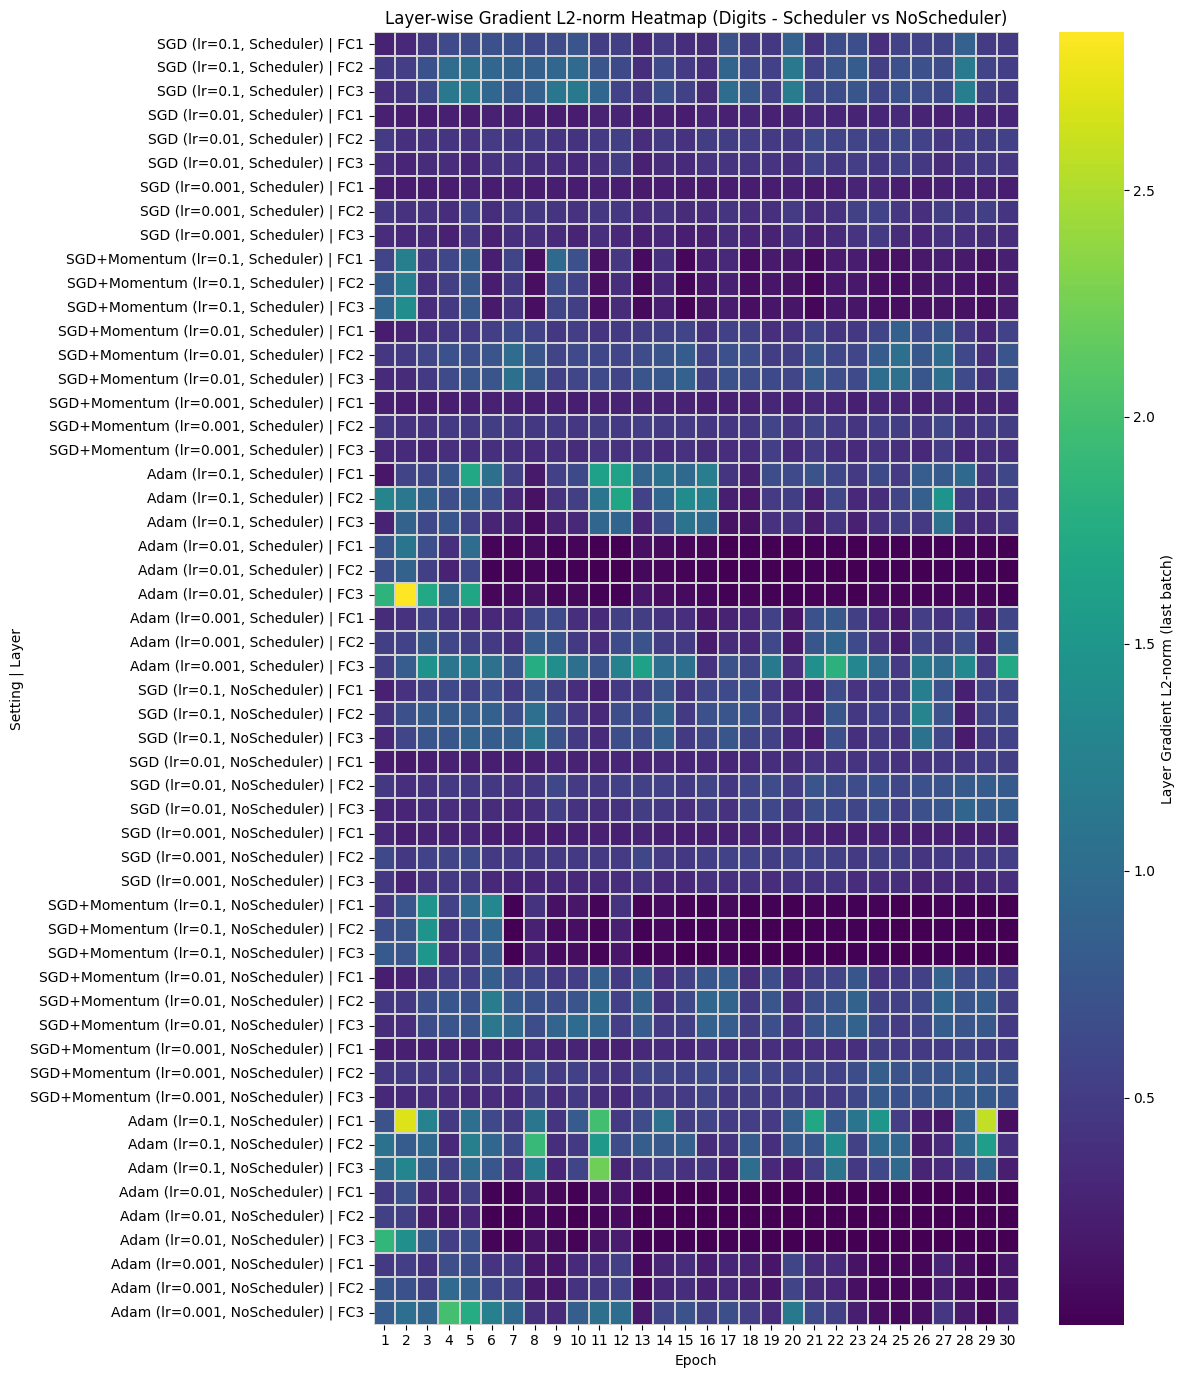

In [16]:
heatmap_data_list, row_labels = [], []
layer_names_for_heatmap = ['FC1', 'FC2', 'FC3'] # 분석 대상
sorted_experiment_keys_heatmap = summary_df['Setting (Opt, LR, Scheduler)'].tolist()

for k_heatmap in sorted_experiment_keys_heatmap: # 각 실험 설정에 대해 반복
    if k_heatmap not in grad_layer_norms: continue # 데이터 없으면 스킵
    for layer_name in layer_names_for_heatmap: # 각 레이어에 대해 반복
        if layer_name in grad_layer_norms[k_heatmap] and grad_layer_norms[k_heatmap][layer_name]:
            series = grad_layer_norms[k_heatmap][layer_name] # 해당 레이어의 norm 데이터
            padded_series = series + [np.nan] * (EPOCHS - len(series)) # 에폭 수에 맞춰 패딩
            heatmap_data_list.append(padded_series[:EPOCHS]) # 히트맵 데이터에 추가
            row_labels.append(f'{k_heatmap} | {layer_name}') # 행 라벨 추가

if heatmap_data_list: #시각화
    heatmap_data_np = np.array(heatmap_data_list)
    plt.figure(figsize=(max(12, EPOCHS * 0.35), max(10, len(row_labels) * 0.22 + 2))) # 동적 크기 조절
    sns.heatmap( # Seaborn 히트맵
        heatmap_data_np, cmap='viridis', cbar_kws={'label': 'Layer Gradient L2-norm (last batch)'},
        yticklabels=row_labels, xticklabels=range(1, EPOCHS + 1) if EPOCHS <= 50 else False,
        linewidths=.2, linecolor='lightgray', annot=False,
    )
    plt.xlabel('Epoch'); plt.ylabel('Setting | Layer')
    plt.title(f'Layer-wise Gradient L2-norm Heatmap (Digits - Scheduler vs NoScheduler)')
    plt.xticks(rotation=0); plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [17]:
optimizer_summary_data = []# 요약표 데이터를 담을 리스트

for opt_to_summarize in OPTIMIZER_NAMES: # 각 옵티마이저 이름 (SGD, SGD+Momentum, Adam)에 대해 반복
    best_final_acc_for_opt = -1.0      # 해당 옵티마이저의 최고 최종 정확도 초기화
    convergence_epoch_at_best_acc = -1 # 위 최고 정확도 달성 시 수렴 에폭
    stability_metric_at_best_acc = float('inf') # 위 최고 정확도 달성 시 안정성 지표(Val Loss Std)
    best_acc_key = None # 최고 정확도를 달성한 실험의 전체 키

    # 현재 옵티마이저(opt_to_summarize)에 해당하는 모든 실험 결과 필터링
    for k, data in history.items():
        opt_name_from_key, _, _ = parse_experiment_key(k) # 키에서 옵티마이저 이름 파싱
        if opt_name_from_key == opt_to_summarize: # 현재 처리 중인 옵티마이저와 일치하면
            if data['val_acc'] and (data['val_acc'][-1] * 100) > best_final_acc_for_opt:
                # 현재까지의 최고 최종 정확도보다 높으면 정보 업데이트
                best_final_acc_for_opt = data['val_acc'][-1] * 100
                best_acc_key = k # 최고 정확도를 낸 실험의 키 저장

    if best_acc_key and history[best_acc_key]['val_loss']: # 최고 정확도 실험이 존재하고, 검증 손실 데이터가 있으면
        val_loss_for_best_run = history[best_acc_key]['val_loss']
        # 최고 정확도를 낸 실험의 검증 손실이 최소가 된 에폭 계산
        convergence_epoch_at_best_acc = np.argmin(val_loss_for_best_run) + 1

        # 안정성 지표 계산: 최고 정확도를 낸 실험의 학습 후반부(절반 이후) 검증 손실 표준편차
        # 에폭 수가 충분히 있어야 의미가 있음 (예: 최소 2 에폭 이상)
        if len(val_loss_for_best_run[EPOCHS//2:]) >= 2 :
             stability_metric_at_best_acc = np.std(val_loss_for_best_run[EPOCHS//2:])
        else: # 데이터 포인트가 너무 적으면 표준편차 계산이 의미 없거나 불가능
             stability_metric_at_best_acc = np.nan # Not a Number로 표시

    # 새 요약표에 추가할 데이터 구성
    optimizer_summary_data.append({
        'Optimizer': opt_to_summarize,
        '최종 정확도 (%)': f"{best_final_acc_for_opt:.2f}" if best_final_acc_for_opt != -1.0 else "N/A",
        '수렴 속도 (Epoch)': convergence_epoch_at_best_acc if convergence_epoch_at_best_acc != -1 else "N/A",
        '안정성 (Val Loss Std)': f"{stability_metric_at_best_acc:.4f}" if not np.isnan(stability_metric_at_best_acc) else "N/A"
    })

# Pandas DataFrame으로 변환하여 출력
summary_df_optimizer_wise = pd.DataFrame(optimizer_summary_data)
display(summary_df_optimizer_wise)

,Optimizer,최종 정확도 (%),수렴 속도 (Epoch),안정성 (Val Loss Std)
0,SGD,95.56,29,0.0251
1,SGD+Momentum,98.06,10,0.0018
2,Adam,98.61,14,0.0020
